In [35]:
from sklearn.model_selection import train_test_split
import pandas
import numpy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from pprint import pprint
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster

**Reading Data**

In [3]:
data = pandas.read_csv('cs-training.csv')

In [4]:
# data.head()

**Removing NaNs and cleaning data**

In [5]:
data.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
data.dropna(axis=0,how='any',subset=['MonthlyIncome'],inplace=True)
data.reset_index()

train_frame = data[data.columns[1:]]
train_frame.columns[1:]

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [6]:
train_frame.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**Creating new features and cleaning more**

In [7]:
train_frame['MonthlyDebt'] = train_frame['DebtRatio']*train_frame['MonthlyIncome']
train_frame['NumOfPastDue'] = train_frame['NumberOfTimes90DaysLate']+train_frame['NumberOfTime60-89DaysPastDueNotWorse'] +train_frame['NumberOfTime30-59DaysPastDueNotWorse']
train_frame['MonthlyBalance'] = train_frame['MonthlyIncome']-train_frame['MonthlyDebt']

# We need only the observations where MonthlyBalance is positive
train_frame = train_frame[train_frame['MonthlyBalance'] > 0]

**Plot the distribution of each variable to see how skewed they are**

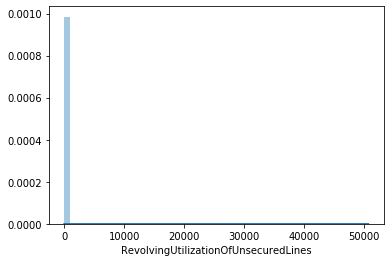

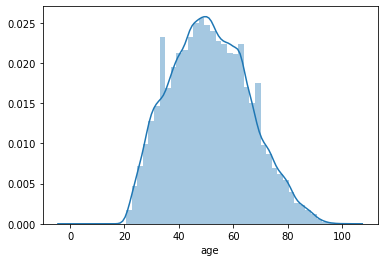

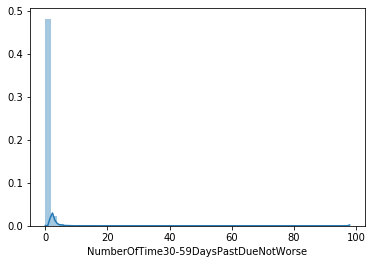

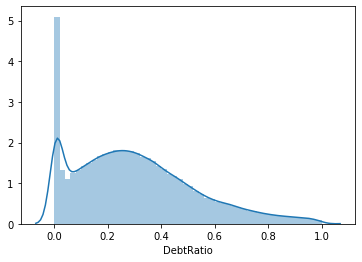

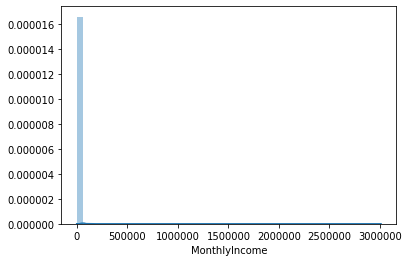

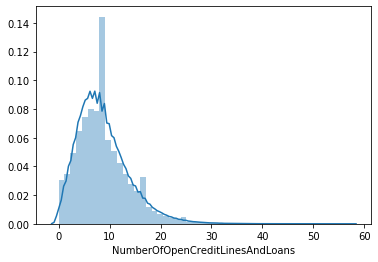

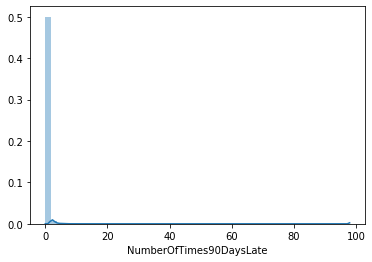

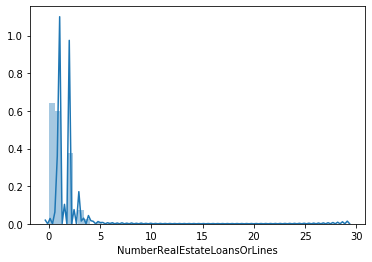

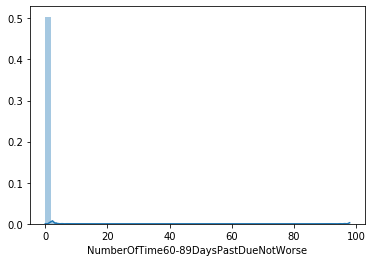

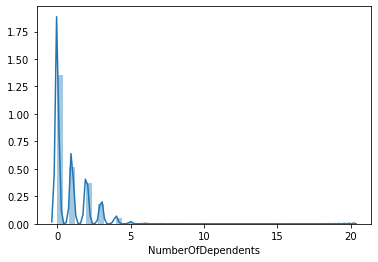

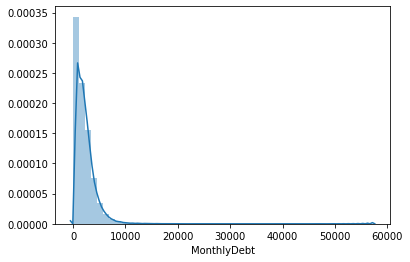

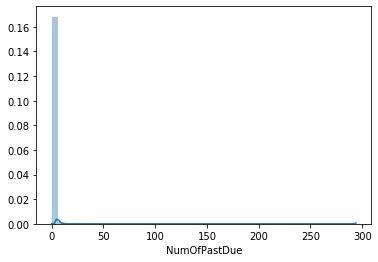

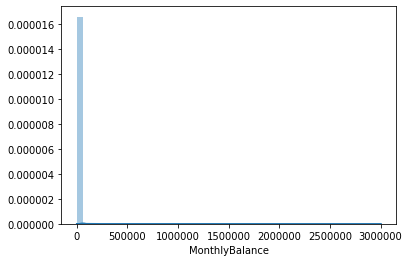

In [8]:
for each in train_frame.columns[1:]:
    sns.distplot(train_frame[each])
    plt.show()

**Taking log transform to reduce skeweness in some variables**

In [9]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyBalance', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines', "NumberOfOpenCreditLinesAndLoans" ]:
    train_frame[column] = numpy.log10(1 + train_frame[column].values)

**Plot distribution again**

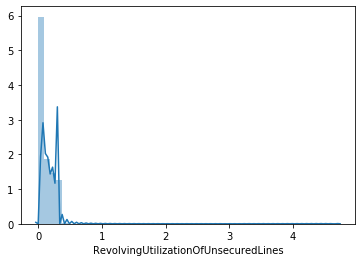

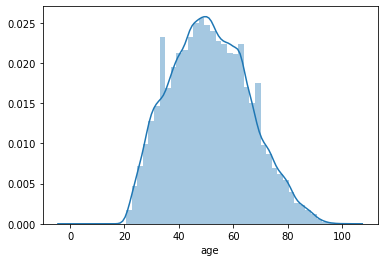

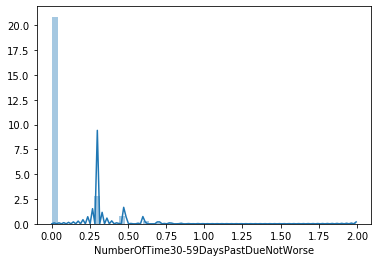

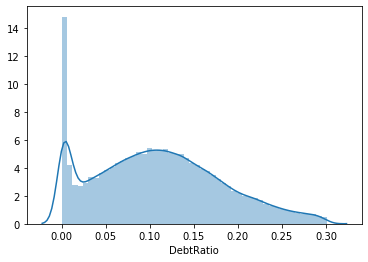

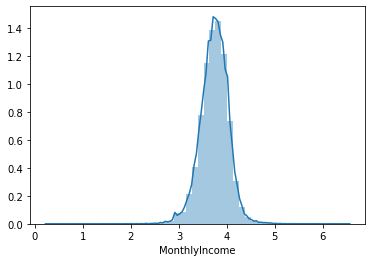

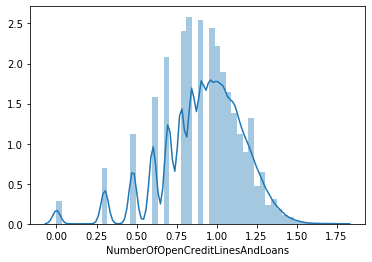

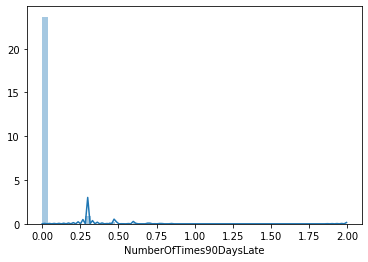

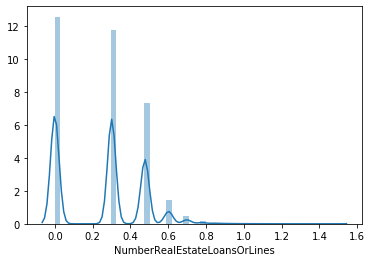

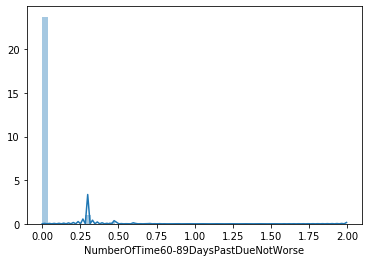

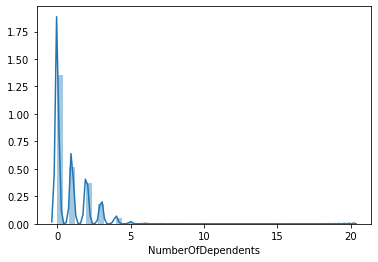

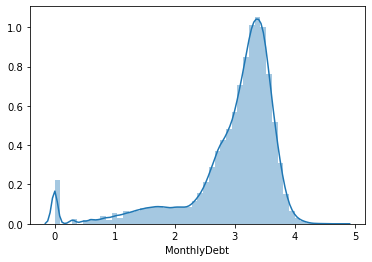

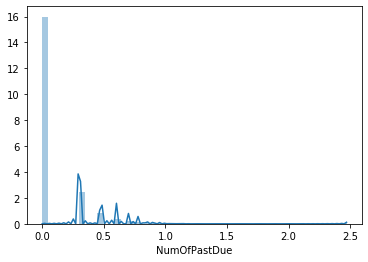

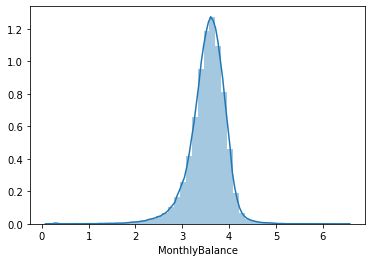

In [10]:
for each in train_frame.columns[1:]:
    sns.distplot(train_frame[each])
    plt.show()

**Removing outliers**

In [11]:
train_frame = train_frame[train_frame['age'] != 0]
train_frame = train_frame[train_frame['age'] !=99]
train_frame = train_frame[train_frame['age'] !=101]

**Choosing features and splitting dataset**

In [12]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'age',
        'MonthlyIncome', 'DebtRatio', 'MonthlyDebt', 'NumOfPastDue', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse',
       'NumberOfDependents']
x = train_frame[features]
y = train_frame['SeriousDlqin2yrs']
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

**Taking a scalar transform**

In [29]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train, x_test = scaler.transform(x_train), scaler.transform(x_test)

In [30]:
def evaluate(X, y_test, y_pred):
    ret_str = ''
    ret_str += 'Adjusted Rand Index: {}'.format( metrics.adjusted_rand_score(y_test, y_pred) ) + '\n'
    ret_str += 'Silhouette Coefficient: {}'.format( metrics.silhouette_score(X, y_pred, metric = "euclidean") )
    return ret_str   

In [31]:
def k_means(X, y_test):
    clustering = KMeans(n_clusters = 2, init = "random", n_init = 3, max_iter=300, tol = 2, random_state = 0, algorithm = "elkan").fit(X)
    clusters = clustering.labels_
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    ax = sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    
    #print(evaluate(x, y_test, clusters))2

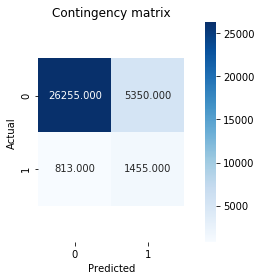

In [32]:
k_means(x_test, y_test)

**Hierarchical**

In [37]:
def hierarchical(X, y_test, method='single', metric='euclidean'):
    clustering = linkage(X, method = method, metric = metric)
    clusters = fcluster(clustering, 2, criterion = 'maxclust')
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))

Adjusted Rand Index: 0.016203977450146193
Silhouette Coefficient: 0.8652695579533421


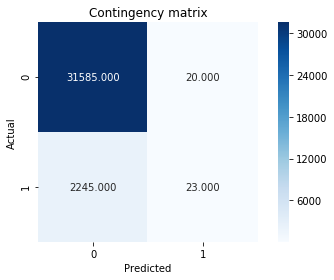

In [40]:
hierarchical(x_test, y_test)

Adjusted Rand Index: 0.17907611381147462
Silhouette Coefficient: 0.2966918567958226


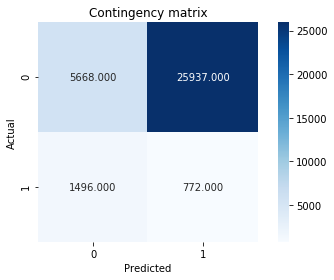

In [42]:
hierarchical(x_test, y_test, method='ward')

**DBSCAN**

In [44]:
def dbscan(X, y_test):
    clustering = DBSCAN(eps = 3, min_samples = 3, metric = "euclidean").fit(X)
    clusters = clustering.labels_
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))

Adjusted Rand Index: 0.02195350045530994
Silhouette Coefficient: 0.6810201694080211


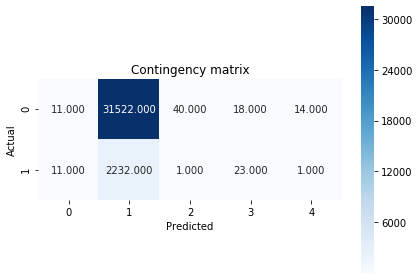

In [45]:
dbscan(x_test, y_test)